# AI and Optimization Approaches for Inverse Kinematics in a 7-DOF Robotic Arm

## Overview

In this notebook we tackle the inverse kinematics issue for 7-DOF robotic arms by developing and analysing several AI models and optimisation strategies. The study specifically examines the following
- AI models
    - Decision Tree Regressor (DTR)
    - Multi-layer Perceptron regressor (MLP)
- Optimisation strategies
    - Simulated Annealing (SA)
    - Particle Swarm Optimisation (PSO)
    - Genetic Algorithms (GA)
    - Differential Evolution (DE)

We investigate how well these approaches map end-effector postures to joint configurations. This was done by
- Modelling the forward kinematics of a given 7-DOF robotic arm.
- Generation of dataset for training generated based on forward kinematics to obtain the position (in cartesian, polar and spherical coordinates system) that corresponded to various joint angles configurations. 
- Iteratively selecting the best hyperparameter values for each approach
- Cross-comparison of the best estimator from each category based on the error between the actual position and the predicted positions.

### Environment setup
This note book was run in python 3.9.6 environment. Run the below command to install the dependencies required to successfully run the notebook

`
pip install jupyter==1.0.0 numpy==1.26.4 pandas==2.2.1 scikit-learn==1.4.1.post1 scikit-opt==0.6.6 matplotlib==3.8.3
`

In [31]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox
# import plotly.graph_objects as go



In [32]:

# Define robot's DH parameters
alpha = [np.deg2rad(90), 0, 0, 0, 0, 0, 0]  # List of link twist angles in radians
a = [0, 1, 1, 1, 1, 1, 1]  # List of link lengths along the common normal
d = [1, 0, 0, 0, 0, 0, 0]  # List of link offsets along the previous z-axis

# Define joint constraints for the robot
joint_constraints = [
    [2*np.pi, 0],  # Joint 1: [max_angle, min_angle] in radians
    [np.pi/2, 0],  # Joint 2: [max_angle, min_angle] in radians
    [np.pi/2, 0],  # Joint 3: [max_angle, min_angle] in radians
    [np.pi/2, 0],  # Joint 4: [max_angle, min_angle] in radians
    [np.pi/2, 0],  # Joint 5: [max_angle, min_angle] in radians
    [np.pi/2, 0],  # Joint 6: [max_angle, min_angle] in radians
    [np.pi/2, 0]   # Joint 7: [max_angle, min_angle] in radians
]



In [33]:

import numpy as np


def forward_kinematics(theta):
    '''
    Function to perform forward kinematics on a given set of joint angles.

    Parameters:
    - theta (list): List of joint angles for the robot arm.

    Returns:
    - position (numpy array): Final position of the end effector.
    - transformations_steps (numpy array): Individual transformation steps for each joint.
    '''
    # Define Denavit-Hartenberg (DH) parameters (alpha, a, d)
    # Note: These parameters should be defined somewhere in the code before calling this function
    dh_params = list(zip(alpha, a, d, theta))

    # Define function to compute Denavit-Hartenberg transformation matrix
    def dh_matrix(alpha, a, d, theta):
        return np.array([
            [np.cos(theta), -np.sin(theta)*np.cos(alpha),
             np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
            [np.sin(theta), np.cos(theta)*np.cos(alpha), -
             np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
            [0, np.sin(alpha), np.cos(alpha), d],
            [0, 0, 0, 1]
        ])

    # Compute transformation matrices for each joint
    T_matrices = [dh_matrix(alpha, a, d, theta)
                  for alpha, a, d, theta in dh_params]

    # Initialize transformation steps with identity matrix for the base frame
    T_prev = np.eye(4)
    transformations_steps = [T_prev[:3, 3]]

    # Compute transformation steps for each joint
    for T in T_matrices:
        T_prev = np.dot(T_prev, T)
        transformations_steps.append(T_prev[:3, 3])

    # Round the transformation steps and final position for better readability
    transformations_steps = np.round(np.asarray(transformations_steps), 4)
    position = np.round(np.array(T_prev[:3, 3]), 4)

    return position, transformations_steps


In [34]:
def cylindrical_to_cartesian(r, theta, z):
    '''
    Function to convert cylindrical cordinates to cartesian cordinates
    '''
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y, z

def cartesian_to_cylindrical(x, y, z):
    '''
    Function to convert cartesian cordinates to cylindrical cordinates
    '''
    # Compute radial distance
    rho = np.sqrt(x**2 + y**2)
    
    # Compute polar angle (theta)
    theta = np.arctan2(y, x)
    
    return rho, theta, z

def cartesian_to_spherical(x, y, z):
    '''
    Function to convert cartesian cordinates to spherical cordinates
    '''
    # Compute radial distance
    r = np.sqrt(x**2 + y**2 + z**2)
    
    # Compute polar angle (theta)
    theta = np.arctan2(y, x)
    
    # Compute azimuthal angle (phi)
    phi = np.arccos(z / r)
    
    return r, theta, phi

In [35]:
def expand_features(x, y, z) -> dict:
    """
    Expands Cartesian coordinates (x, y, z) to include additional coordinate systems.

    Parameters:
    - x (float): x-coordinate
    - y (float): y-coordinate
    - z (float): z-coordinate

    Returns:
    - dict: Dictionary containing expanded features including Cartesian, spherical, and cylindrical coordinates.
    """
    
    # Convert Cartesian coordinates to spherical coordinates
    r, theta, phi = cartesian_to_spherical(x, y, z)

    # Convert Cartesian coordinates to cylindrical coordinates
    rho, theta, z = cartesian_to_cylindrical(x, y, z)

    # Return dictionary containing expanded features
    return {
        'x': x,          # Original x-coordinate
        'y': y,          # Original y-coordinate
        'z': z,          # Original z-coordinate
        'r': r,          # Radius in spherical coordinates
        'rho': rho,      # Radius in cylindrical coordinates
        'theta': theta,  # Angle theta in spherical and cylindrical coordinates
        'phi': phi,      # Angle phi in spherical coordinates
    }


In [36]:


def set_axes_equal_2d(ax):
    """
    Make axes of 2D plot have equal scale so that squares appear as squares, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range,])

    ax.set_xlim([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim([y_middle - plot_radius, y_middle + plot_radius])

def set_axes_equal_3d(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])



In [37]:
def plot_robot(joint_angles, actual=[0,0,0]):
    """
    Plots the robot arm in various perspectives based on the given joint angles.

    Parameters:
    - joint_angles (list): List of joint angles for the robot arm.
    - actual (list, optional): Actual end effector position. Defaults to [0,0,0].

    Returns:
    - None
    """

    # Create a new figure
    fig = plt.figure()

    # Perform forward kinematics to get the points of the robot arm
    _, points = forward_kinematics(joint_angles)

    # Add subplots for each perspective
    xy = fig.add_subplot(221)
    xy.set_title("Top")
    xy.set_xlabel('X')
    xy.set_ylabel('Y')

    yz = fig.add_subplot(222)
    yz.set_title("Side")
    yz.set_xlabel('Y')
    yz.set_ylabel('Z')

    xz = fig.add_subplot(223)
    xz.set_title("Front")
    xz.set_xlabel('X')
    xz.set_ylabel('Z')

    xyz = fig.add_subplot(224, projection="3d")
    xyz.set_title("3D")
    xyz.set_xlabel('X')
    xyz.set_ylabel('Y')
    xyz.set_zlabel('Z')
    
    # Extract x, y, z coordinates from points
    x_coords = points[:,0]
    y_coords = points[:,1]
    z_coords = points[:,2]

    # Plot the robot arm in each perspective
    c = 'black'  # Color of the robot arm
    xy.plot(x_coords, y_coords, c=c, marker='o')
    yz.plot(y_coords, z_coords, c=c, marker='o')
    xz.plot(x_coords, z_coords, c=c, marker='o')
    xyz.plot(x_coords, y_coords, z_coords, c=c, marker='o')

    # Plot the actual end effector position
    xy.plot(actual[0], actual[1], c='r', marker='o')
    yz.plot(actual[1], actual[2], c='r', marker='o')
    xz.plot(actual[0], actual[2], c='r', marker='o')
    xyz.plot(*actual, c='r', marker='o')

    # Set the aspect ratio of 2D subplots to be equal
    for ax in [xy, xz, yz]:
        ax.set_box_aspect(1)
        set_axes_equal_2d(ax)

    # Set the aspect ratio of 3D subplot to be equal
    xyz.set_box_aspect((1, 1, 1))
    set_axes_equal_3d(xyz)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


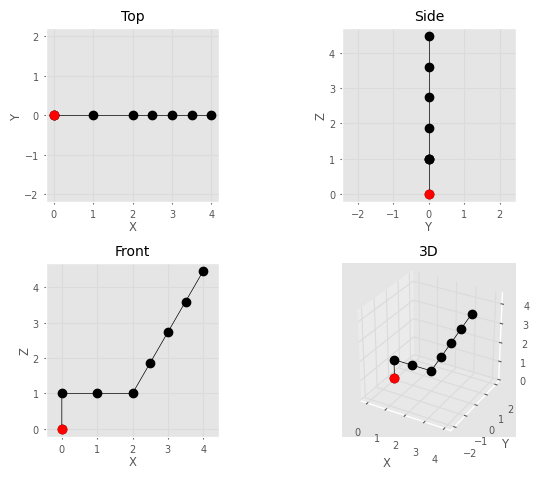

In [38]:

joint_angles = [np.deg2rad(x) for x in [
    0,0,0,60,0,0,0
]]

plot_robot(joint_angles,)

In [39]:
def plot_positions(positions):
    '''
    Function to plot positions in 2D space.

    Parameters:
    - positions (numpy array): Array containing x, y, z positions of the end effector.

    Returns:
    - None
    '''
    # Extract x, y, z coordinates from positions array
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    # Create a new figure
    fig = plt.figure()

    # Loop through different 2D projections (XY, XZ, YZ)
    i = 0
    for xx, yy, xlabel, ylabel in [(x, y, 'X', 'Y'), (x, z, 'X', 'Z'), (y, z, 'Y', 'Z')]:
        i += 1
        # Add subplot for each projection
        ax = fig.add_subplot(int(f'13{i}'))
        # Scatter plot of positions in the current projection
        ax.scatter(xx, yy)
        # Set labels and aspect ratio
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_box_aspect(1)
        set_axes_equal_2d(ax)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


## Dataset Generation

In [40]:
import pandas as pd

# Define joint names using list comprehension
joint_names = [f'j{i}' for i in range(1, 8)]  # List of joint names 'j1' to 'j7'

# Define column names for the DataFrame
columns = ['x', 'y', 'z', 'r', 'rho', 'theta', 'phi', *joint_names]
# Columns: x, y, z represent Cartesian coordinates, r, rho, theta, phi represent spherical coordinates,
# and joint_names represent joint angles

# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=columns)

# Display the first few rows of the DataFrame
df.head()


,x,y,z,r,rho,theta,phi,j1,j2,j3,j4,j5,j6,j7


In [41]:
import pandas as pd
import numpy as np

# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=columns)

# Set seed for reproducibility
np.random.seed(10)

# Loop until DataFrame has 1000 entries
while len(df.index) < 1000:
    # Generate random joint angles within the specified constraints
    angles = [np.random.uniform(*value) for value in joint_constraints]

    # Perform forward kinematics to get end effector position
    position, _ = forward_kinematics(angles)
    x, y, z = position
    
    # Skip if the position is at the origin
    if x == 0 and y == 0 and z == 0:
        continue

    # Expand features based on end effector position
    extra_features = expand_features(x, y, z)

    # Skip if phi is greater than pi/2
    if extra_features['phi'] > np.pi/2:
        continue

    # Create entry for DataFrame with expanded features and joint angles
    entry = {
        **extra_features,
        **{name: ang for name, ang in zip(joint_names, angles)},
    }

    # Add entry to DataFrame
    df.loc[len(df.index)] = entry

# Round values in DataFrame to 3 decimal places
df = df.round(3)

# Print shape of DataFrame and display the first few rows
print(df.shape)
df.head()


(1000, 14)


,x,y,z,r,rho,theta,phi,j1,j2,j3,j4,j5,j6,j7
0,-0.214,-1.588,1.825,2.429,1.603,-1.705,0.721,1.437,1.538,0.575,0.395,0.788,1.218,1.260
1,-0.112,-1.682,0.515,1.763,1.686,-1.637,1.274,1.505,1.305,1.432,0.494,0.073,1.565,0.766
2,-0.674,-1.625,4.111,4.472,1.759,-1.964,0.404,1.177,0.609,0.437,1.112,0.129,0.448,0.719
3,-1.204,1.496,1.749,2.597,1.920,2.248,0.832,5.390,0.984,0.512,0.877,0.889,0.600,0.765
4,0.181,-0.250,3.667,3.680,0.309,-0.945,0.084,2.197,0.627,0.306,0.751,0.143,1.069,1.429


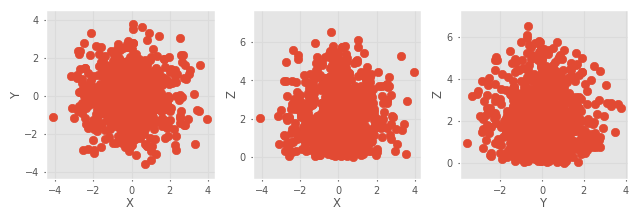

In [42]:
plot_positions(df[['x','y','z']].values)

In [43]:
from sklearn.metrics import make_scorer


def evaluate_prediction(positions: list, angles: list):
    '''
    Function to evaluate the prediction error between actual and predicted end effector positions.
    
    Parameters:
    - positions (list): List of actual end effector positions.
    - angles (list): List of predicted joint angles.

    Returns:
    - error (float): Mean absolute error between actual and predicted positions.
    '''
    distance_errors = []
    
    # Calculate distance error for each pair of actual and predicted positions
    for position, angle in list(zip(positions, angles)):
        end_effector_position, _ = forward_kinematics(angle)
        error = np.linalg.norm(end_effector_position - position)
        distance_errors.append(error)

    # Calculate mean absolute error
    error = np.round(np.mean(np.absolute(distance_errors)), 3)

    return error


def optimization_scorer():
    '''
    Function to create a custom optimization scorer for evaluating prediction performance.
    
    Returns:
    - scorer (callable): Custom scorer function.
    '''
    def scorer(y_true, y_pred):
        '''
        Custom scoring function for optimization.
        
        Parameters:
        - y_true (array-like): True end effector positions.
        - y_pred (array-like): Predicted joint angles.

        Returns:
        - score (float): Optimization score based on mean absolute distance error.
        '''
        distance_errors = []

        # Calculate distance error for each pair of true and predicted positions
        for actual, predicted in list(zip(y_true, y_pred)):
            pos_true, _ = forward_kinematics(actual)
            pos_pred, _ = forward_kinematics(predicted)
            d = np.linalg.norm(pos_true - pos_pred)
            distance_errors.append(d)
        
        # Calculate optimization score
        score = -np.mean(np.abs(distance_errors))
        return score

    # Return custom scorer using make_scorer
    return make_scorer(scorer)


In [44]:
# Define columns representing Cartesian coordinates
cart_columns = [
    'x',
    'y',
    'z',
]

# Set seed for reproducibility
np.random.seed(10)

# Randomly choose 7 indices from the DataFrame
index_choices = np.random.randint(0, len(df), 7)

# Select Cartesian positions and corresponding joint angles based on chosen indices
pos_choices = df[cart_columns].iloc[index_choices].values  # Cartesian positions
angle_choices = df[joint_names].iloc[index_choices].values  # Joint angles


In [45]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning


def do_grid_search(estimator, params, X, y, x_plot=None, stringify_xplot=False, bar_plot=False, xticks_rotation=0) -> pd.DataFrame:
    '''
    Function to perform grid search with cross-validation and visualize results.

    Parameters:
    - estimator (object): Estimator object implementing 'fit' and 'predict' methods.
    - params (dict): Dictionary with parameters names (str) as keys and lists of parameter settings as values.
    - X (array-like): Input features for training.
    - y (array-like): Target variable for training.
    - x_plot (str or None): Parameter to plot on x-axis (optional).
    - stringify_xplot (bool): Whether to convert x_plot values to strings for plotting (optional).
    - bar_plot (bool): Whether to plot a bar plot instead of a line plot (optional).
    - xticks_rotation (int): Rotation angle for x-axis tick labels (optional).

    Returns:
    - results (DataFrame): DataFrame containing grid search results sorted by mean absolute error (MAE).
    '''

    # Filter out convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Perform grid search with cross-validation
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        cv=len(pos_choices),  # Number of folds for cross-validation
        scoring=optimization_scorer(),  # Scoring metric
        verbose=1,
    )

    gs.fit(X, y)

    # Extract grid search results
    results = pd.DataFrame(gs.cv_results_)

    # Rename columns for readability
    result_columns = {
        **{f'param_{key}': key for key in params.keys()},  # Rename param_* columns with parameter names
        'mean_test_score': "MAE",  # Rename mean_test_score column to MAE (Mean Absolute Error)
    }
    for key, value in result_columns.items():
        results = results.rename(columns={key: value})

    # Invert MAE values to represent optimization score
    results['MAE'] = results['MAE'] * -1

    # Visualize results if x_plot is specified
    if x_plot is not None:
        key = f'{x_plot}'
        graph = results.sort_values(key)

        # Plotting
        if stringify_xplot:
            x_plot_str = [str(x) for x in graph[key]]
            plt.plot(x_plot_str, graph["MAE"], marker='o') if not bar_plot else plt.bar(
                x_plot_str, graph["MAE"])
            plt.xticks(x_plot_str)
        else:
            plt.plot(graph[key], graph["MAE"], marker='o') if not bar_plot else plt.bar(
                graph[key], graph["MAE"])
            plt.xticks(list(graph[key].values))
        
        plt.ylabel('MAE')  # Set y-axis label
        plt.xlabel(x_plot)  # Set x-axis label
        plt.xticks(rotation=xticks_rotation)  # Rotate x-axis tick labels
        plt.show()  # Display plot

    # Return results DataFrame sorted by MAE
    return results[result_columns.values()].sort_values('MAE')


## Optimization Algorithms Implementation

In [46]:
from sklearn.base import BaseEstimator, RegressorMixin
from sko.GA import GA


class GA_Optimizer(BaseEstimator, RegressorMixin):
    '''
    Genetic Algorithm (GA) Optimizer for joint angle prediction.

    Parameters:
    - pop_size (int): Population size for genetic algorithm.
    - max_iteration (int): Maximum number of iterations for genetic algorithm.
    - mutation (float): Mutation probability for genetic algorithm.

    Attributes:
    - pop_size (int): Population size for genetic algorithm.
    - max_iteration (int): Maximum number of iterations for genetic algorithm.
    - mutation (float): Mutation probability for genetic algorithm.
    '''

    def __init__(self, pop_size=None, max_iteration=None, mutation=None):
        self.pop_size = pop_size
        self.max_iteration = max_iteration
        self.mutation = mutation

    def fit(self, X, y=None):
        '''
        Fit method for the genetic algorithm optimizer.
        
        Parameters:
        - X (array-like): Input features (not used in fitting).
        - y (array-like): Target variable (not used in fitting).
        
        Returns:
        - self (object): Instance of the estimator.
        '''
        return self

    def predict(self, X):
        '''
        Predict method to predict joint angles using genetic algorithm optimization.
        
        Parameters:
        - X (array-like): Input features containing end effector positions.
        
        Returns:
        - predictions (list): Predicted joint angles for each input position.
        '''
        predictions: list = []  # Initialize list to store predictions
        
        # Iterate over each end effector position
        for position in X:
            np.random.seed(1)  # Set seed for reproducibility
            
            # Initialize genetic algorithm with specified parameters
            ga = GA(
                func=lambda y: evaluate_prediction([position], [y]),
                n_dim=7,
                size_pop=self.pop_size,
                max_iter=self.max_iteration,
                prob_mut=self.mutation,
                lb=[x[1] for x in joint_constraints],
                ub=[x[0] for x in joint_constraints],
                precision=1e-7,
            )

            # Run genetic algorithm to find optimal joint angles
            y_pred, _ = ga.run()
            predictions.append(y_pred)  # Append predicted joint angles to list of predictions
        
        return predictions  # Return list of predicted joint angles


In [47]:
from sklearn.base import BaseEstimator, RegressorMixin
from sko.DE import DE


class DE_Optimizer(BaseEstimator, RegressorMixin):
    '''
    Differential Evolution (DE) Optimizer for joint angle prediction.

    Parameters:
    - pop_size (int): Population size for differential evolution.
    - max_iteration (int): Maximum number of iterations for differential evolution.
    - mutation (float): Mutation probability for differential evolution.

    Attributes:
    - pop_size (int): Population size for differential evolution.
    - max_iteration (int): Maximum number of iterations for differential evolution.
    - mutation (float): Mutation probability for differential evolution.
    '''

    def __init__(self, pop_size=None, max_iteration=None, mutation=None):
        self.pop_size = pop_size
        self.max_iteration = max_iteration
        self.mutation = mutation

    def fit(self, X, y=None):
        '''
        Fit method for the differential evolution optimizer.
        
        Parameters:
        - X (array-like): Input features (not used in fitting).
        - y (array-like): Target variable (not used in fitting).
        
        Returns:
        - self (object): Instance of the estimator.
        '''
        return self

    def predict(self, X):
        '''
        Predict method to predict joint angles using differential evolution optimization.
        
        Parameters:
        - X (array-like): Input features containing end effector positions.
        
        Returns:
        - predictions (list): Predicted joint angles for each input position.
        '''
        predictions: list = []  # Initialize list to store predictions
        
        # Iterate over each end effector position
        for position in X:
            np.random.seed(1)  # Set seed for reproducibility
            
            # Initialize differential evolution with specified parameters
            de = DE(
                func=lambda y: evaluate_prediction([position], [y]),
                n_dim=7,
                size_pop=self.pop_size,
                max_iter=self.max_iteration,
                prob_mut=self.mutation,
                lb=[x[1] for x in joint_constraints],
                ub=[x[0] for x in joint_constraints],
            )

            # Run differential evolution to find optimal joint angles
            y_pred, _ = de.run()
            predictions.append(y_pred)  # Append predicted joint angles to list of predictions
        
        return predictions  # Return list of predicted joint angles


In [48]:
from sklearn.base import BaseEstimator, RegressorMixin
from sko.PSO import PSO


class PSO_Optimizer(BaseEstimator, RegressorMixin):
    '''
    Particle Swarm Optimization (PSO) Optimizer for joint angle prediction.

    Parameters:
    - pop_size (int): Population size for particle swarm optimization.
    - max_iteration (int): Maximum number of iterations for particle swarm optimization.
    - inertia (float): Inertia weight for particle swarm optimization.
    - cognitive_param (float): Cognitive parameter for particle swarm optimization.
    - social_param (float): Social parameter for particle swarm optimization.

    Attributes:
    - pop_size (int): Population size for particle swarm optimization.
    - max_iteration (int): Maximum number of iterations for particle swarm optimization.
    - inertia (float): Inertia weight for particle swarm optimization.
    - cognitive_param (float): Cognitive parameter for particle swarm optimization.
    - social_param (float): Social parameter for particle swarm optimization.
    '''

    def __init__(
            self,
            pop_size=None,
            max_iteration=None,
            inertia=None,
            cognitive_param=None,
            social_param=None
    ):
        self.pop_size = pop_size
        self.max_iteration = max_iteration
        self.inertia = inertia
        self.cognitive_param = cognitive_param
        self.social_param = social_param

    def fit(self, X, y=None):
        '''
        Fit method for the particle swarm optimization optimizer.
        
        Parameters:
        - X (array-like): Input features (not used in fitting).
        - y (array-like): Target variable (not used in fitting).
        
        Returns:
        - self (object): Instance of the estimator.
        '''
        return self

    def predict(self, X):
        '''
        Predict method to predict joint angles using particle swarm optimization.
        
        Parameters:
        - X (array-like): Input features containing end effector positions.
        
        Returns:
        - predictions (list): Predicted joint angles for each input position.
        '''
        predictions: list = []  # Initialize list to store predictions
        
        # Iterate over each end effector position
        for position in X:
            np.random.seed(1)  # Set seed for reproducibility
            
            # Initialize particle swarm optimization with specified parameters
            pso = PSO(
                func=lambda y: evaluate_prediction([position], [y]),
                n_dim=7,
                pop=self.pop_size,
                max_iter=self.max_iteration,
                w=self.social_param,
                c1=self.cognitive_param,
                c2=self.social_param,
                lb=[x[1] for x in joint_constraints],
                ub=[x[0] for x in joint_constraints],
            )

            # Run particle swarm optimization to find optimal joint angles
            y_pred, _ = pso.run()
            predictions.append(y_pred)  # Append predicted joint angles to list of predictions
        
        return predictions  # Return list of predicted joint angles


In [49]:
from sklearn.base import BaseEstimator, RegressorMixin
from sko.SA import SAFast


class SA_Optimizer(BaseEstimator, RegressorMixin):
    '''
    Simulated Annealing (SA) Optimizer for joint angle prediction.

    Parameters:
    - iteration_count (int): Number of iterations for simulated annealing.
    - T_min (float): Minimum temperature for simulated annealing.
    - T_max (float): Maximum temperature for simulated annealing.

    Attributes:
    - iteration_count (int): Number of iterations for simulated annealing.
    - T_min (float): Minimum temperature for simulated annealing.
    - T_max (float): Maximum temperature for simulated annealing.
    '''

    def __init__(
            self,
            iteration_count=None,
            T_min=None,
            T_max=None
    ):
        self.iteration_count = iteration_count
        self.T_min = T_min
        self.T_max = T_max

    def fit(self, X, y=None):
        '''
        Fit method for the simulated annealing optimizer.
        
        Parameters:
        - X (array-like): Input features (not used in fitting).
        - y (array-like): Target variable (not used in fitting).
        
        Returns:
        - self (object): Instance of the estimator.
        '''
        return self

    def predict(self, X):
        '''
        Predict method to predict joint angles using simulated annealing.
        
        Parameters:
        - X (array-like): Input features containing end effector positions.
        
        Returns:
        - predictions (list): Predicted joint angles for each input position.
        '''
        predictions: list = []  # Initialize list to store predictions
        
        # Iterate over each end effector position
        for position in X:
            np.random.seed(1)  # Set seed for reproducibility
            
            # Initialize simulated annealing with specified parameters
            sa = SAFast(
                func=lambda y: evaluate_prediction([position], [y]),
                x0=[0, 0, 0, 0, 0, 0, 0],  # Initial guess for joint angles
                T_max=self.T_max,
                T_min=self.T_min,
                L=self.iteration_count,
            )

            # Run simulated annealing to find optimal joint angles
            y_pred, _ = sa.run()
            predictions.append(y_pred)  # Append predicted joint angles to list of predictions
        
        return predictions  # Return list of predicted joint angles


## GA Hyperparameters Selection

Fitting 7 folds for each of 5 candidates, totalling 35 fits


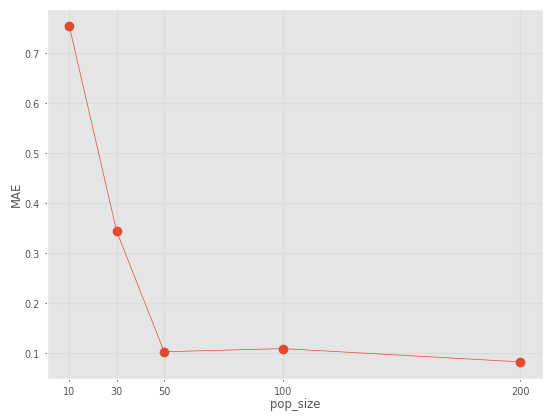

,pop_size,max_iteration,mutation,MAE
4,200,10,0.0,0.082448
2,50,10,0.0,0.102636
3,100,10,0.0,0.109003
1,30,10,0.0,0.343511
0,10,10,0.0,0.755009


In [50]:
# varing the population size
params = {
    'pop_size': [10, 30, 50, 100, 200],
    'max_iteration': [10],
    'mutation': [0.0],
}

result=do_grid_search(
    estimator=GA_Optimizer(), 
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='pop_size'
    )
result


Fitting 7 folds for each of 5 candidates, totalling 35 fits


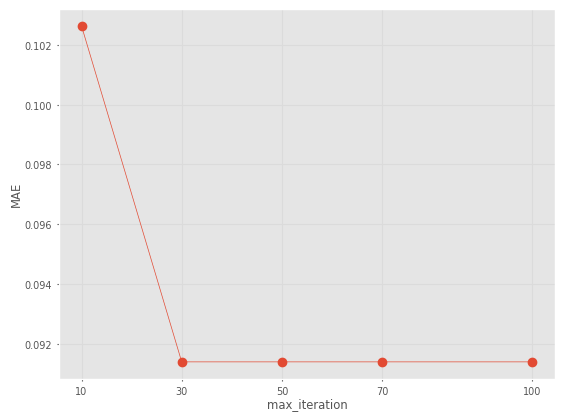

,pop_size,max_iteration,mutation,MAE
1,50,30,0.0,0.091389
2,50,50,0.0,0.091389
3,50,70,0.0,0.091389
4,50,100,0.0,0.091389
0,50,10,0.0,0.102636


In [51]:
# varing the maximum iteration
params = {
    'pop_size': [50],
    'max_iteration': [10, 30, 50, 70, 100,],
    'mutation': [0.0],
}

result = do_grid_search(
    estimator=GA_Optimizer(),
    params=params, 
    X=pos_choices, 
    y=angle_choices,
    x_plot='max_iteration',

    )
result


Fitting 7 folds for each of 10 candidates, totalling 70 fits


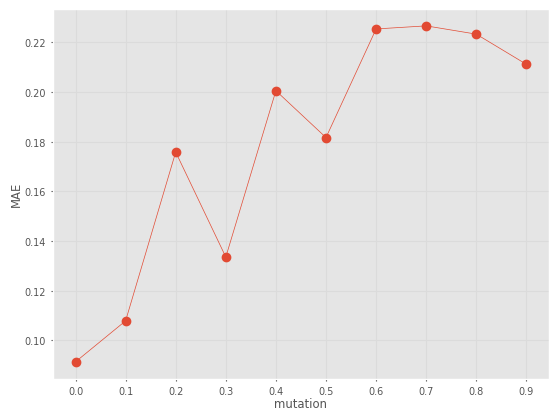

,pop_size,max_iteration,mutation,MAE
0,50,30,0.0,0.091389
1,50,30,0.1,0.107893
3,50,30,0.3,0.133579
2,50,30,0.2,0.175807
5,50,30,0.5,0.181660
4,50,30,0.4,0.200507
9,50,30,0.9,0.211136
8,50,30,0.8,0.223277
6,50,30,0.6,0.225369
7,50,30,0.7,0.226610


In [52]:
# varying the mutation probability
params = {
    'pop_size': [50],
    'max_iteration': [30],
    'mutation': [x*0.1 for x in range(0,10)],
}

result = do_grid_search(
    estimator=GA_Optimizer(), 
    params=params,
    X=pos_choices, 
    y=angle_choices,
    x_plot='mutation',
    )
result


In [53]:
best_ga= GA_Optimizer(
    max_iteration=50,
    pop_size=200,
    mutation=0.1,
)

## DE Hyperparameters Selection

Fitting 7 folds for each of 5 candidates, totalling 35 fits


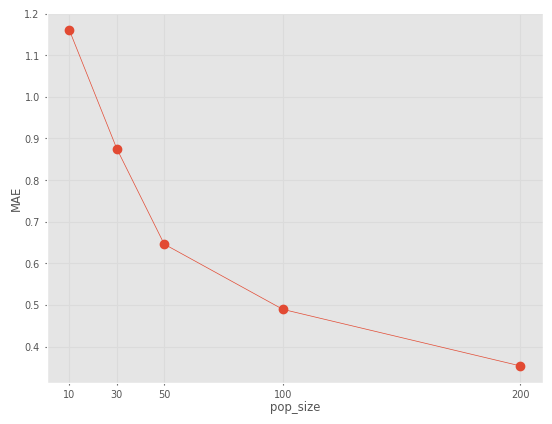

,pop_size,max_iteration,mutation,MAE
4,200,10,0.0,0.353903
3,100,10,0.0,0.489629
2,50,10,0.0,0.646348
1,30,10,0.0,0.875871
0,10,10,0.0,1.160889


In [54]:
# varing the population size
params = {
    'pop_size': [10, 30, 50, 100, 200],
    'max_iteration': [10],
    'mutation': [0.0],
}

result=do_grid_search(
    estimator=DE_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='pop_size',
    )
result

Fitting 7 folds for each of 5 candidates, totalling 35 fits


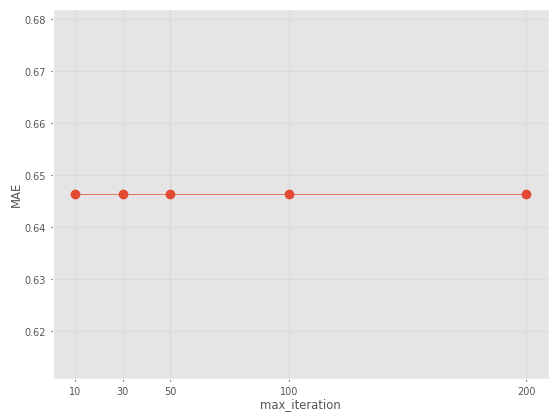

,pop_size,max_iteration,mutation,MAE
0,50,10,0.0,0.646348
1,50,30,0.0,0.646348
2,50,50,0.0,0.646348
3,50,100,0.0,0.646348
4,50,200,0.0,0.646348


In [55]:
# varing the max_iteration
params = {
    'pop_size': [50],
    'max_iteration': [10, 30, 50,100,200],
    'mutation': [0.0],
}

result=do_grid_search(
    estimator=DE_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='max_iteration',
    )
result

Fitting 7 folds for each of 10 candidates, totalling 70 fits


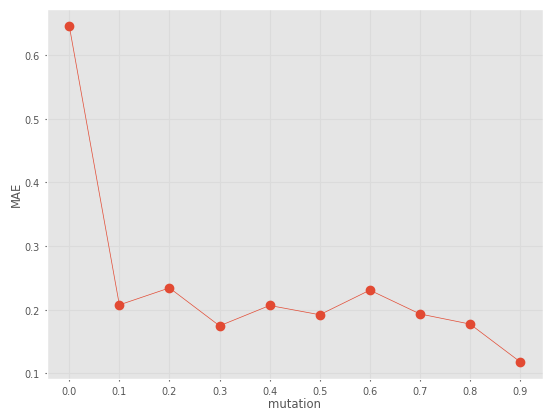

,pop_size,max_iteration,mutation,MAE
9,50,10,0.9,0.117777
3,50,10,0.3,0.174451
8,50,10,0.8,0.177221
5,50,10,0.5,0.191906
7,50,10,0.7,0.193149
4,50,10,0.4,0.206472
1,50,10,0.1,0.207397
6,50,10,0.6,0.230605
2,50,10,0.2,0.234121
0,50,10,0.0,0.646348


In [56]:
# varing the probability mutation
params = {
    'pop_size': [50],
    'max_iteration': [10,],
    'mutation': [x*0.1 for x in range(0,10)],
}

result=do_grid_search(
    estimator=DE_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='mutation',
    )
result

In [57]:
best_de=DE_Optimizer(
    pop_size=200,
    max_iteration=50,
    mutation=0.9
)

## PSO Hyperparameters Selection

Fitting 7 folds for each of 5 candidates, totalling 35 fits


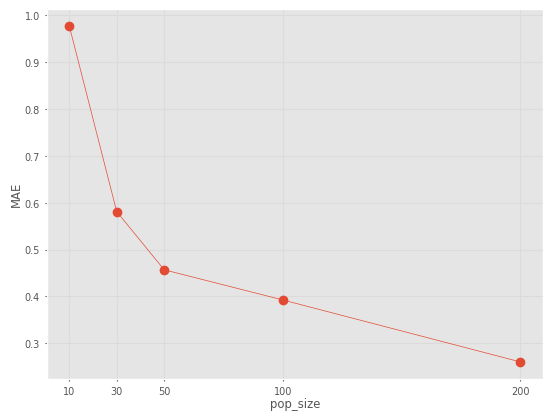

,pop_size,max_iteration,inertia,cognitive_param,social_param,MAE
4,200,10,0.1,0.1,0.1,0.260409
3,100,10,0.1,0.1,0.1,0.392450
2,50,10,0.1,0.1,0.1,0.456814
1,30,10,0.1,0.1,0.1,0.580813
0,10,10,0.1,0.1,0.1,0.977069


In [58]:
# varing the population size
params = {
    'pop_size': [10, 30, 50, 100, 200],
    'max_iteration': [10],
    "inertia": [0.1],
    "cognitive_param": [0.1],
    "social_param": [0.1]
}

result = do_grid_search(
    estimator=PSO_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='pop_size',
)
result


Fitting 7 folds for each of 5 candidates, totalling 35 fits


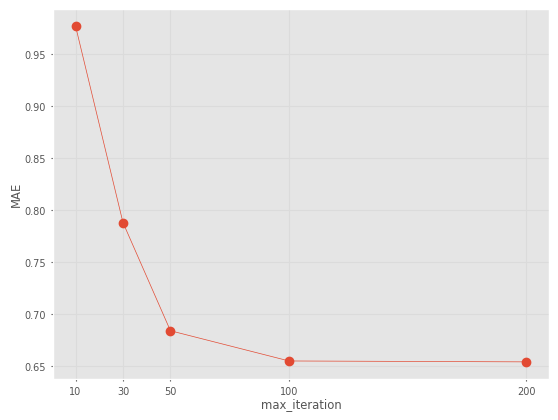

,pop_size,max_iteration,inertia,cognitive_param,social_param,MAE
4,10,200,0.1,0.1,0.1,0.653666
3,10,100,0.1,0.1,0.1,0.654531
2,10,50,0.1,0.1,0.1,0.683623
1,10,30,0.1,0.1,0.1,0.787767
0,10,10,0.1,0.1,0.1,0.977069


In [59]:
# varing the max_iteration
params = {
    'pop_size': [10],
    'max_iteration': [10, 30, 50, 100, 200],
    "inertia" : [0.1],
    "cognitive_param" : [0.1],
    "social_param" : [0.1]
}


result = do_grid_search(
    estimator=PSO_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='max_iteration',
)
result


Fitting 7 folds for each of 11 candidates, totalling 77 fits


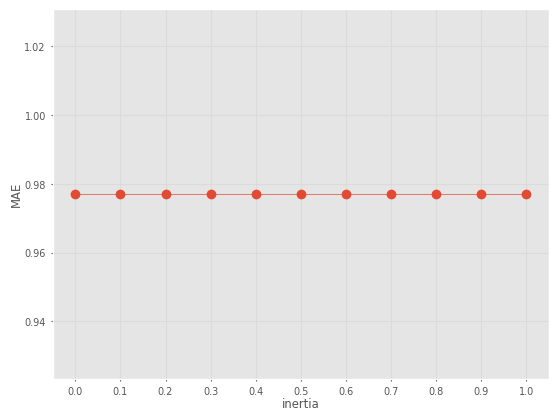

,pop_size,max_iteration,inertia,cognitive_param,social_param,MAE
0,10,10,0.0,0.1,0.1,0.977069
1,10,10,0.1,0.1,0.1,0.977069
2,10,10,0.2,0.1,0.1,0.977069
3,10,10,0.3,0.1,0.1,0.977069
4,10,10,0.4,0.1,0.1,0.977069
5,10,10,0.5,0.1,0.1,0.977069
6,10,10,0.6,0.1,0.1,0.977069
7,10,10,0.7,0.1,0.1,0.977069
8,10,10,0.8,0.1,0.1,0.977069
9,10,10,0.9,0.1,0.1,0.977069


In [60]:
# varing the inertia
params = {
    'pop_size': [10],
    'max_iteration': [10],
    "inertia" : [x*0.1 for x in range(11)],
    "cognitive_param" : [0.1],
    "social_param" : [0.1]
}

result = do_grid_search(
    estimator=PSO_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='inertia',
)
result


Fitting 7 folds for each of 11 candidates, totalling 77 fits
Fitting 7 folds for each of 11 candidates, totalling 77 fits
Fitting 7 folds for each of 11 candidates, totalling 77 fits
Fitting 7 folds for each of 11 candidates, totalling 77 fits
Fitting 7 folds for each of 11 candidates, totalling 77 fits


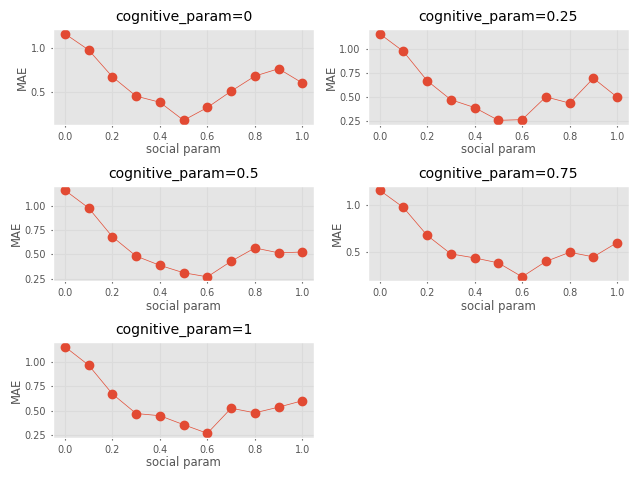

In [61]:
# varing the cognitive_param and social_param simultaneously

fig = plt.figure()


interval = [0,  0.25, 0.5,  0.75,  1]
for count, i in enumerate(interval, 1):
    ax = fig.add_subplot(3, 2, count)
    params = {
        'pop_size': [10],
        'max_iteration': [10],
        "inertia": [0.1],
        "cognitive_param": [i],
        "social_param": [x*0.1 for x in range(11)],
    }

    result = do_grid_search(
        estimator=PSO_Optimizer(),
        params=params,
        X=pos_choices,
        y=angle_choices,
    )
    result = result.sort_values('social_param')
    ax.plot(result['social_param'].values, result['MAE'].values, marker='o')
    ax.set_title(f'cognitive_param={i}')
    ax.set_ylabel('MAE')
    ax.set_xlabel('social param')
    # ax.set_xticks(list(result['social_param'].values))

fig.tight_layout()

plt.show()


In [62]:
best_pso=PSO_Optimizer(
    pop_size=200,
    max_iteration=100,
    cognitive_param=0.25,
    social_param=0.5,
    inertia=0.1,
)

## SA Hyperparameters Selection

Fitting 7 folds for each of 7 candidates, totalling 49 fits


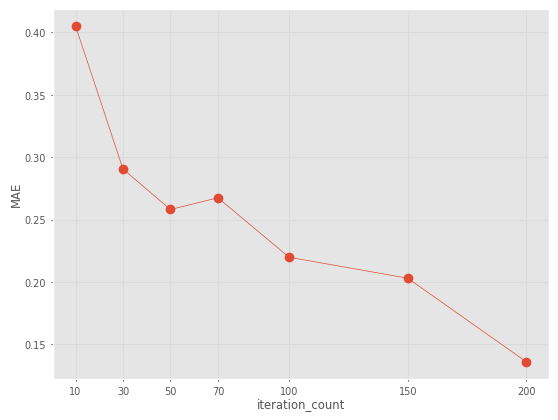

,iteration_count,T_max,T_min,MAE
6,200,10,0.1,0.136070
5,150,10,0.1,0.203034
4,100,10,0.1,0.219811
2,50,10,0.1,0.258056
3,70,10,0.1,0.267426
1,30,10,0.1,0.290436
0,10,10,0.1,0.405041


In [63]:
# varing the iteration_count
params = {
    'iteration_count':[10, 30, 50,70, 100,150, 200],
    'T_max': [10],
    'T_min': [0.1]
}

result = do_grid_search(
    estimator=SA_Optimizer(),
    params=params,
    X=pos_choices,
    y=angle_choices,
    x_plot='iteration_count'
)
result


Fitting 7 folds for each of 7 candidates, totalling 49 fits
Fitting 7 folds for each of 7 candidates, totalling 49 fits
Fitting 7 folds for each of 7 candidates, totalling 49 fits
Fitting 7 folds for each of 7 candidates, totalling 49 fits
Fitting 7 folds for each of 7 candidates, totalling 49 fits
Fitting 7 folds for each of 7 candidates, totalling 49 fits


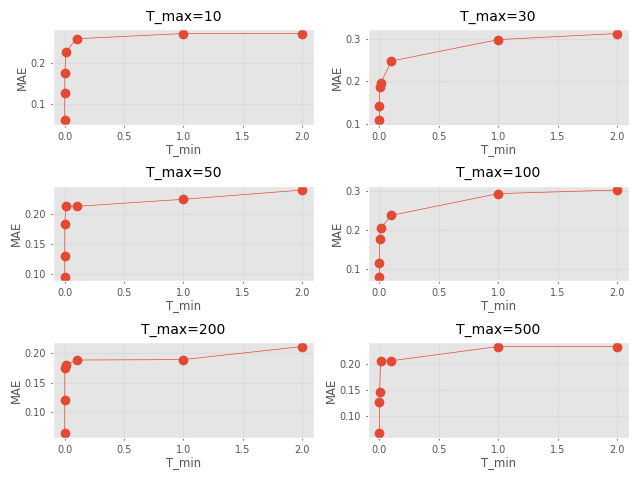

In [64]:
# varing the T_max and T_min simultaneously
fig = plt.figure()


interval = [10, 30, 50, 100, 200,500]

for count, i in enumerate(interval, 1):
    ax = fig.add_subplot(3, 2, count)
    params = {
        'iteration_count': [50],
        'T_max': [i],
        'T_min': [1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
    }
    result = do_grid_search(
        estimator=SA_Optimizer(),
        params=params,
        X=pos_choices,
        y=angle_choices,
    )
    result = result.sort_values('T_min')
    ax.plot(result['T_min'].values, result['MAE'].values, marker='o')
    ax.set_title(f'T_max={i}')
    ax.set_ylabel('MAE')
    ax.set_xlabel('T_min')
    # ax.set_xticks(list(result['social_param'].values))

fig.tight_layout()

plt.show()


In [65]:
best_sa=SA_Optimizer(
    iteration_count=200,
    T_max=100,
    T_min=1e-5,
)

## Data Splitting For Model Training

DF
Training Size:  200


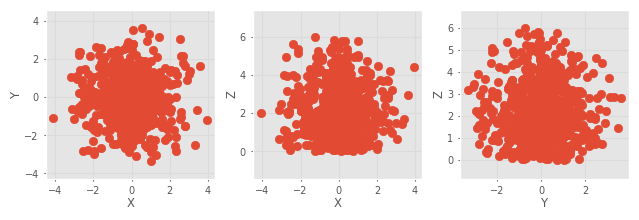

Test Size:  200


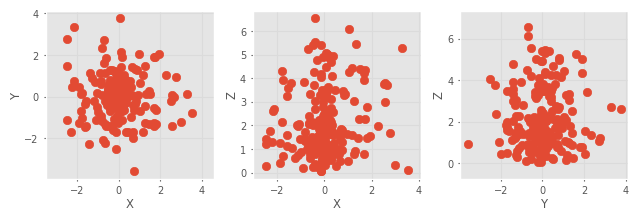

In [66]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# 80% of the data will be used for training, and 20% for testing
# Random state is set for reproducibility
df_train: pd.DataFrame  # Define variable for training set
df_test: pd.DataFrame  # Define variable for test set
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=10,)

# Print information about the data
print('DF')  # Print heading for the data
print('Training Size: ', len(df_test))  # Print size of training set
plot_positions(df_train[['x', 'y', 'z']].values)  # Plot positions for training set
print('Test Size: ', len(df_test))  # Print size of test set
plot_positions(df_test[['x', 'y', 'z']].values)  # Plot positions for test set


In [67]:
# Define the list of features
features = [
    'x',
    'y',
    'z',
    'r',
    'rho',
    'theta',
    'phi'
]

# Define the maximum values for each feature
features_max_values = {
    'x': 6,
    'y': 6,
    'z': 6,
    'r': 6,
    'rho': 6,
    'theta': 2 * np.pi,
    'phi': np.pi,
    **{joint_name: joint_angle for joint_name, joint_angle in list(zip(joint_names, [u for u, _ in joint_constraints]))},
}

# Define the minimum values for each feature
features_min_values = {
    'x': 0,
    'y': 0,
    'z': 0,
    'r': 0,
    'rho': 0,
    'theta': 0,
    'phi': 0,
    **{joint_name: joint_angle for joint_name, joint_angle in list(zip(joint_names, [l for _, l in joint_constraints]))},
}

# Create DataFrames for maximum and minimum values of features
features_max_df = pd.DataFrame(features_max_values, index=[0])
features_min_df = pd.DataFrame(features_min_values, index=[0])

# Create a combined DataFrame containing both maximum and minimum values
features_combined_df = pd.DataFrame(
    [features_min_values, features_max_values], index=[0, 1])


def do_max_scaling(features: list[str], dataframe: pd.DataFrame):
    '''
    Function to perform max scaling on specified features of a DataFrame

    Args:
        features (list[str]): List of feature names to be scaled
        dataframe (pd.DataFrame): DataFrame containing the features

    Returns:
        pd.DataFrame: DataFrame with the scaled features
    '''
    modified_df = dataframe[features].values / features_max_df[features].values
    return pd.DataFrame(modified_df, columns=features)


def undo_max_scaling(features: list[str], array: np.array):
    '''
    Function to undo max scaling on specified features of a NumPy array

    Args:
        features (list[str]): List of feature names to be unscaled
        array (np.array): NumPy array containing the scaled features

    Returns:
        pd.DataFrame: DataFrame with the unscaled features
    '''
    modified_array = array * features_max_df[features].values
    return pd.DataFrame(modified_array, columns=features)


In [68]:
# List of feature combinations
features_combinations = [
    ['x', 'y', 'z'],
    ['z', 'rho', 'theta'],
    ['r', 'theta', 'phi'],
    ['x', 'y', 'z', 'r', 'rho', 'theta', 'phi'],
    ['z', 'r', 'rho', 'theta', 'phi'],
    ['x', 'y', 'z', 'theta', 'phi'],
    ['r', 'rho', 'theta', 'phi'],
    ['x', 'y', 'z', 'r', 'rho', 'theta'],
    ['rho', 'theta', 'phi'],
]

## Decision Tree Regressor Hyperparameters Selection

<BarContainer object of 9 artists>

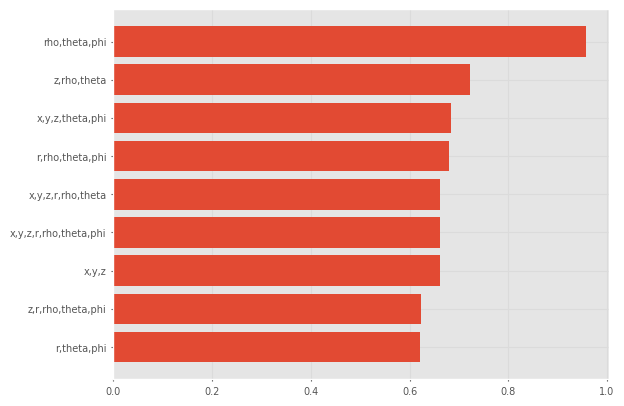

In [69]:
from sklearn.tree import DecisionTreeRegressor

# Initialize a list to store the results
data = []

# Loop through each feature combination
for features in features_combinations:

    # Extract training and test data based on current feature combination
    X_train = df_train[features].values
    Y_train = df_train[joint_names].values
    X_test = df_test[features].values

    # Initialize DecisionTreeRegressor with hyperparameters
    tree = DecisionTreeRegressor(
        max_depth=30,
        max_features=7,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=10,
    )

    # Fit the model on training data
    tree = tree.fit(X_train, Y_train)

    # Make predictions on test data
    y_pred = tree.predict(X_test)

    # Calculate Mean Absolute Error (MAE) without scaling
    mae_without_scaling = evaluate_prediction(
        df_test[['x', 'y', 'z']].values, y_pred)

    # Append results to the data list
    data.append([','.join(features), mae_without_scaling])

# Convert the results to a DataFrame
data = pd.DataFrame(data, columns=['features', 'MAE'])

# Sort the DataFrame based on MAE
data = data.sort_values('MAE')

# Plot a horizontal bar chart showing MAE for each feature combination
plt.barh(data['features'], data['MAE'])


In [70]:
# Define the list of features selected as the best by the decision tree model
best_tree_features = ['r', 'theta', 'phi']



Fitting 7 folds for each of 11 candidates, totalling 77 fits


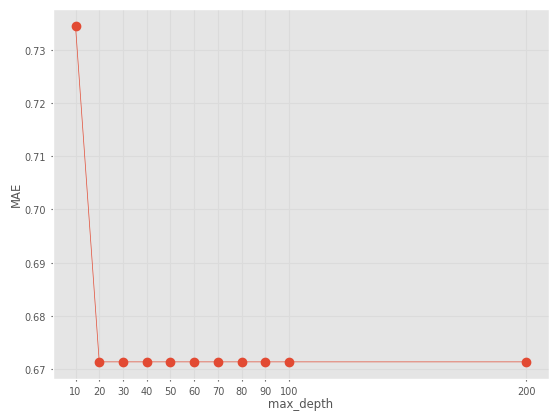

,max_depth,max_features,min_samples_split,min_samples_leaf,random_state,MAE
1,20,7,2,1,10,0.671342
2,30,7,2,1,10,0.671342
3,40,7,2,1,10,0.671342
4,50,7,2,1,10,0.671342
5,60,7,2,1,10,0.671342
6,70,7,2,1,10,0.671342
7,80,7,2,1,10,0.671342
8,90,7,2,1,10,0.671342
9,100,7,2,1,10,0.671342
10,200,7,2,1,10,0.671342


In [71]:
# varying the max_depth
from sklearn.tree import DecisionTreeRegressor


X_train = df_train[best_tree_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_tree_features].values

param_grid = {
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200],
    "max_features": [7,],
    "min_samples_split": [2,],
    "min_samples_leaf": [1],
    "random_state": [10],
}


result = do_grid_search(
    DecisionTreeRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='max_depth'
)

result


Fitting 7 folds for each of 9 candidates, totalling 63 fits


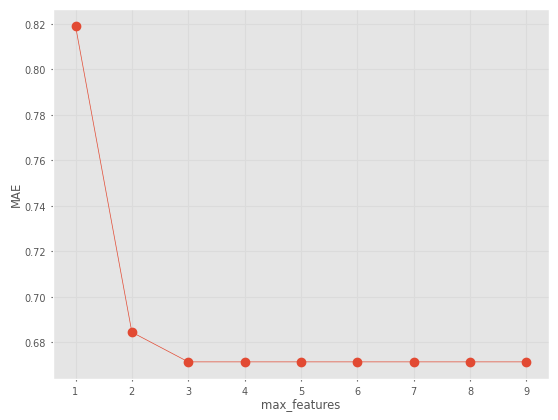

,max_depth,max_features,min_samples_split,min_samples_leaf,random_state,MAE
2,30,3,2,1,10,0.671342
3,30,4,2,1,10,0.671342
4,30,5,2,1,10,0.671342
5,30,6,2,1,10,0.671342
6,30,7,2,1,10,0.671342
7,30,8,2,1,10,0.671342
8,30,9,2,1,10,0.671342
1,30,2,2,1,10,0.684389
0,30,1,2,1,10,0.819155


In [72]:
# varying the max_features
from sklearn.tree import DecisionTreeRegressor


X_train = df_train[best_tree_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_tree_features].values

param_grid = {
        "max_depth": [30],
        "max_features": [1,2,3,4,5,6,7,8,9],
        "min_samples_split": [2,],
        "min_samples_leaf": [1],
        "random_state": [10],
    }


result = do_grid_search(
    DecisionTreeRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='max_features'
)

result


Fitting 7 folds for each of 5 candidates, totalling 35 fits


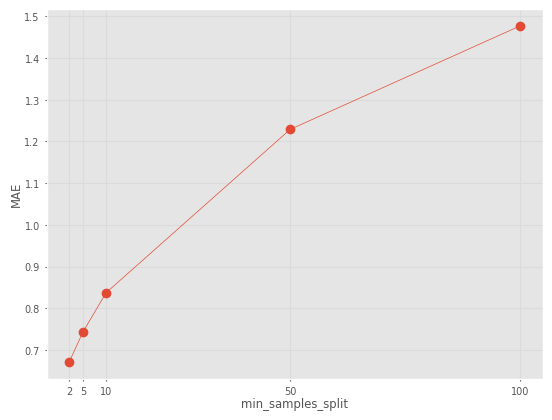

,max_depth,max_features,min_samples_split,min_samples_leaf,random_state,MAE
0,30,7,2,1,10,0.671342
1,30,7,5,1,10,0.743469
2,30,7,10,1,10,0.837039
3,30,7,50,1,10,1.228862
4,30,7,100,1,10,1.477298


In [73]:
# varying the min_samples_split

from sklearn.tree import DecisionTreeRegressor


X_train = df_train[best_tree_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_tree_features].values

param_grid = {
        "max_depth": [30],
        "max_features": [7],
        "min_samples_split": [2,5,10,50,100],
        "min_samples_leaf": [1],
        "random_state": [10],
    }


result = do_grid_search(
    DecisionTreeRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='min_samples_split'
)

result


Fitting 7 folds for each of 5 candidates, totalling 35 fits


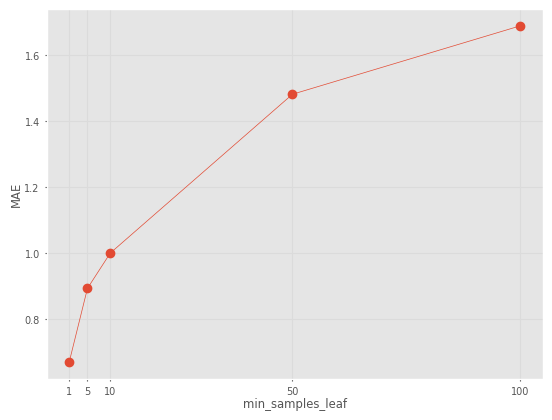

,max_depth,max_features,min_samples_split,min_samples_leaf,random_state,MAE
0,30,7,2,1,10,0.671342
1,30,7,2,5,10,0.893656
2,30,7,2,10,10,1.000134
3,30,7,2,50,10,1.480432
4,30,7,2,100,10,1.687194


In [74]:
# varying the min_samples_leaf

from sklearn.tree import DecisionTreeRegressor



X_train = df_train[best_tree_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_tree_features].values

param_grid = {
        "max_depth": [30],
        "max_features": [7],
        "min_samples_split": [2,],
        "min_samples_leaf": [1,5,10,50,100],
        "random_state": [10],
    }


result = do_grid_search(
    DecisionTreeRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='min_samples_leaf'
)

result


In [75]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=30,
    max_features=7,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=10,
)
X_train = df_train[best_tree_features]
Y_train = df_train[joint_names]
X_test = df_test[best_tree_features]
best_tree = tree.fit(X_train, Y_train)



## MLP Hyperparameters Selection

In [76]:
best_mlp_features=['x', 'y', 'z', 'r', 'rho', 'theta', 'phi'] 

Fitting 7 folds for each of 6 candidates, totalling 42 fits


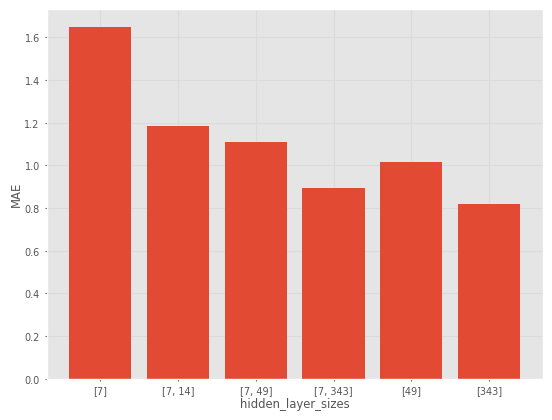

In [77]:
# varying the hidden_layer_sizes
from sklearn.neural_network import MLPRegressor


X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7],
        [7, 14],
        [7, 7**2],
        [7**2],
        [7**3],
        [7,7**3],
    ],
    "activation": ['relu'],
    "solver": ['adam'],
    "max_iter": [10],
    "learning_rate": ['constant'],
    "learning_rate_init": [0.001],
    "random_state": [10],
    "batch_size": [5],
}


result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='hidden_layer_sizes',
    stringify_xplot=True,
    bar_plot=True
)


Fitting 7 folds for each of 4 candidates, totalling 28 fits


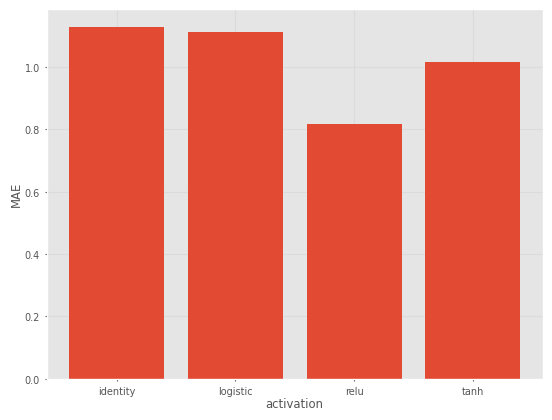

In [78]:
# varying the activation function
from sklearn.neural_network import MLPRegressor


X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7**3],
    ],
    "activation": ['identity', 'logistic', 'tanh', 'relu',],
    "solver": ['adam'],
    "max_iter": [10],
    "learning_rate": ['constant'],
    "learning_rate_init": [0.001],
    "random_state": [10],
    "batch_size": [5],
}


result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='activation',
    bar_plot=True
)


Fitting 7 folds for each of 2 candidates, totalling 14 fits
Fitting 7 folds for each of 2 candidates, totalling 14 fits


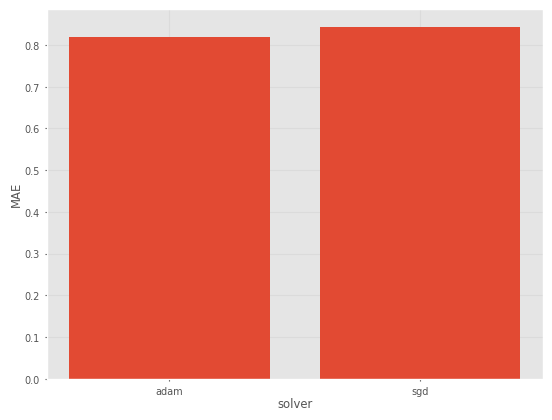

In [79]:
# varying the solver
from sklearn.neural_network import MLPRegressor


X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7**3],
    ],
    "activation": ['relu'],
    "solver": ['adam','sgd'],
    "max_iter": [10],
    "learning_rate": ['constant'],
    "learning_rate_init": [0.001],
    "random_state": [10],
    "batch_size": [5],
}


result = do_grid_search(MLPRegressor(), param_grid, X_train, Y_train)

result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='solver',
    bar_plot=True
)


Fitting 7 folds for each of 5 candidates, totalling 35 fits


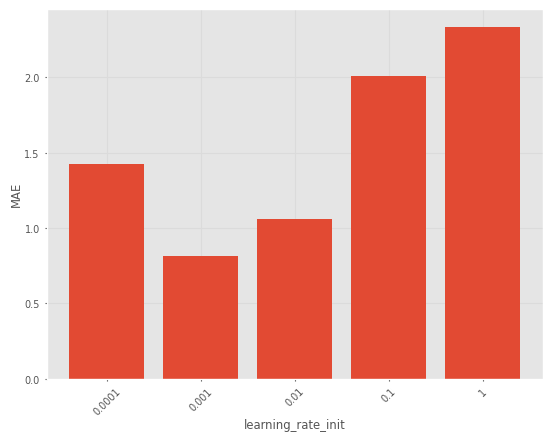

In [80]:
# varying the learning_rate_init
from sklearn.neural_network import MLPRegressor

X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7**3],
    ],
    "activation": ['relu'],
    "solver": [ 'adam'],
    "max_iter": [10],
    "learning_rate": ['constant'],
    "learning_rate_init": [1e-4,1e-3,1e-2,1e-1,1],
    "random_state": [10],
    "batch_size": [5],
}


result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='learning_rate_init',
    xticks_rotation=45,
    stringify_xplot=True,
    bar_plot=True
)


Fitting 7 folds for each of 3 candidates, totalling 21 fits


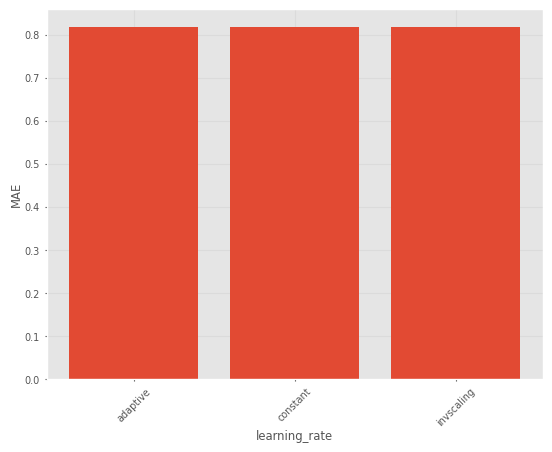

In [81]:
# varying the learning_rate strategy
from sklearn.neural_network import MLPRegressor

X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7**3],
        
    ],
    "activation": ['relu'],
    "solver": [ 'adam'],
    "max_iter": [10],
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "learning_rate_init": [0.001],
    "random_state": [10],
    "batch_size": [5],
}


result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='learning_rate',
    xticks_rotation=45,
    stringify_xplot=True,
    bar_plot=True
)


Fitting 7 folds for each of 4 candidates, totalling 28 fits


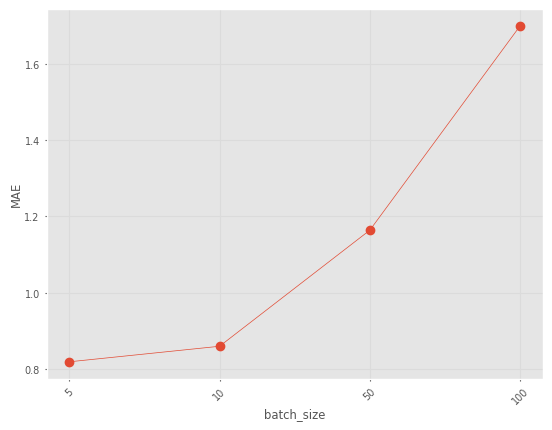

In [82]:
# varying the batch_size
from sklearn.neural_network import MLPRegressor


X_train = df_train[best_mlp_features].values
Y_train = df_train[joint_names].values
X_test = df_test[best_mlp_features].values

param_grid = {
    "hidden_layer_sizes": [
        [7**3],
    ],
    "activation": ['relu'],
    "solver": [ 'adam'],
    "max_iter": [10],
    "learning_rate": ['constant'],
    "learning_rate_init": [0.001],
    "random_state": [10],
    "batch_size": [5,10,50,100],
}


result = do_grid_search(
    MLPRegressor(),
    param_grid,
    X_train,
    Y_train,
    x_plot='batch_size',
    xticks_rotation=45,
    stringify_xplot=True,
    # bar_plot=True
)


In [83]:
from sklearn.neural_network import MLPRegressor

mlp1=MLPRegressor(
    hidden_layer_sizes= [7**3],
    activation='relu',
    solver='adam',
    max_iter=200,
    learning_rate='constant',
    learning_rate_init=0.001,
    random_state=10,
    batch_size=5,
    
)
X_train = df_train[best_mlp_features]
Y_train = df_train[joint_names]
X_test = df_test[best_mlp_features]
best_mlp = mlp1.fit(X_train, Y_train)



## Reinforced Learning 

## Cross-comparison of the best estimators from each category


In [84]:
np.random.seed(5)
positions = np.asarray([[1,3,2]])


Best GA
MAE:  0.062


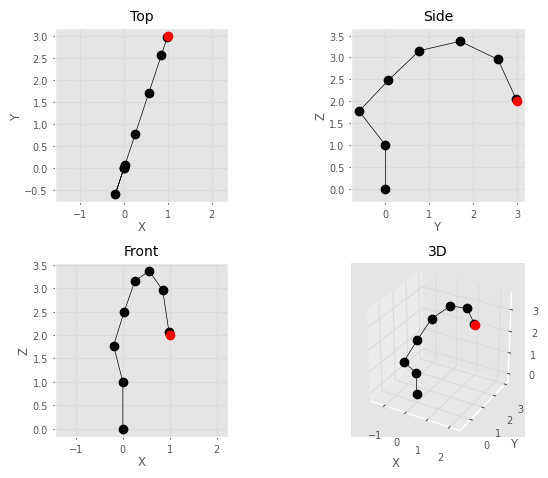

In [85]:

predictions=best_ga.predict(positions)

print('Best GA')
print('MAE: ',evaluate_prediction(positions,predictions))

for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)
    
    

Best DE
MAE:  0.006


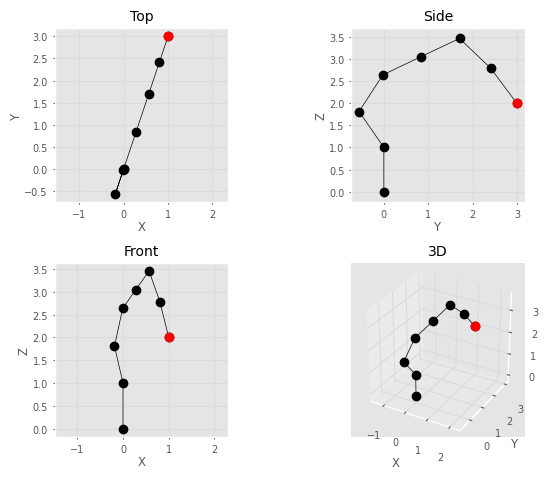

In [86]:

predictions=best_de.predict(positions)
print('Best DE')
print('MAE: ',evaluate_prediction(positions,predictions))
for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)

Best PSO
MAE:  0.0


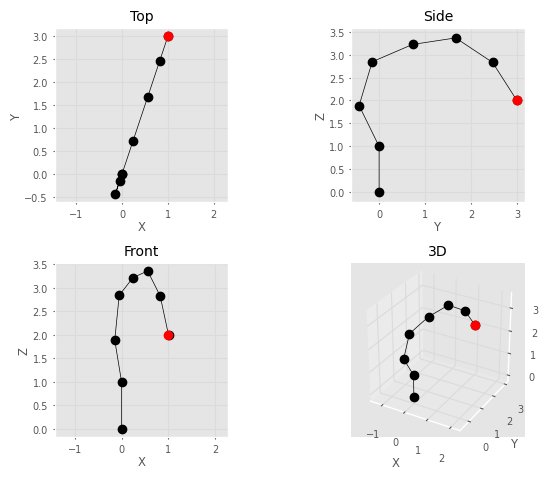

In [87]:

predictions=best_pso.predict(positions)
print('Best PSO')
print('MAE: ',evaluate_prediction(positions,predictions))
for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)

Best SA
MAE:  0.014


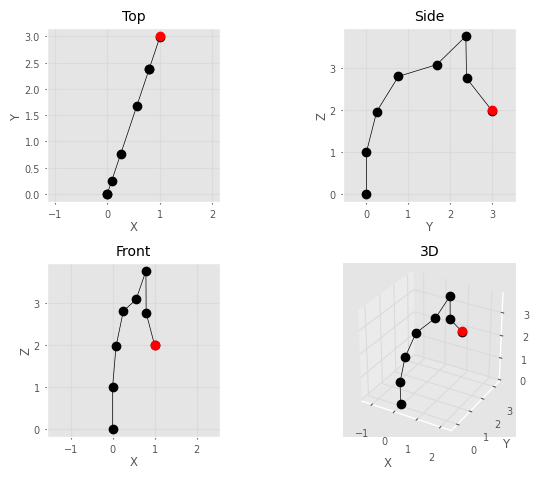

In [88]:

predictions=best_sa.predict(positions)
print('Best SA')
print('MAE: ',evaluate_prediction(positions,predictions))
for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)

Best DTR
MAE:  0.315


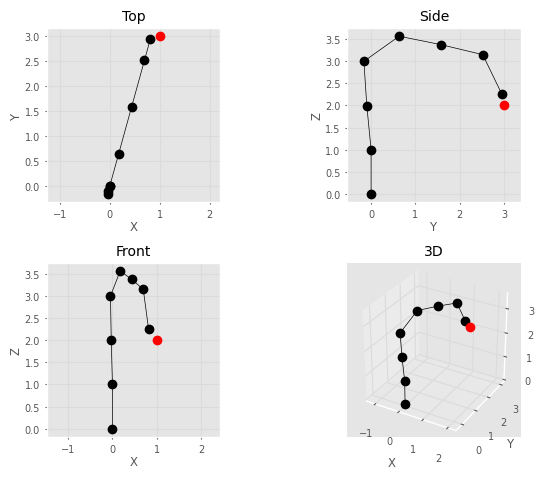

In [89]:

expanded_features=pd.DataFrame(expand_features(*positions[0,:]),index=[0])

predictions=best_tree.predict(expanded_features[best_tree_features])

print('Best DTR')
print('MAE: ',evaluate_prediction(positions,predictions))

for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)

Best MLP
MAE:  1.316


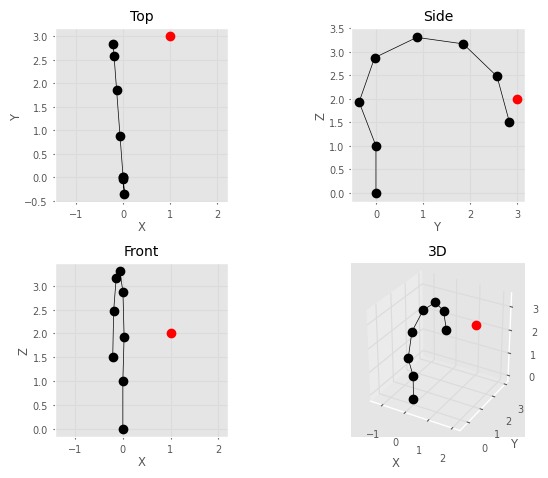

In [90]:

expanded_features=pd.DataFrame(expand_features(*positions[0,:]),index=[0])[best_mlp_features]

predictions=best_mlp.predict(expanded_features)

print('Best MLP')
print('MAE: ',evaluate_prediction(positions,predictions))

for prediction,position in zip(predictions,positions):
    plot_robot(prediction,position)